## Analyses of online job posts
Job postings on City of New York's jobs site, downloaded from Data.gov
#### Exploratory data analysis
#### Predictive modeling (regression, random forest)
Can we predict the salary of a job based on its description in online posts?
<br> Which positions/skills/fields are associated with higher salaries and are more in demand?
#### Topic modeling and recommender system using Non-negative Matrix factorization (NMF)
What career options can someone with a particular degree (e.g. psychology) consider? what are some common job responsibilities of psychology related careers?
<br> Which job posts are similar to a chosen post?

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

#### data reading and manipulation

In [2]:
df = pd.read_csv('C:/Users/Zhang/Desktop/jobs/NYC_jobs.csv')

In [4]:
# remove duplicated postings (same id id)
df = df.drop_duplicates(['Job ID'], keep='first')

In [5]:
# select columns to be used for analyses and rename columns
columns = ['Job ID', 'Agency', 'Business Title', 'Job Category', 'Full-Time/Part-Time indicator', 'Salary Range From',
           'Salary Range To', 'Salary Frequency', 'Job Description', 'Minimum Qual Requirements',
          'Preferred Skills', 'Hours/Shift', 'Posting Date']
df = df[columns]
df.columns = ['id', 'agency', 'title', 'category', 'full_time', 'salary_from', 'salary_to', 'salary_frequency',
              'job_description', 'required_qual', 'preferred_skills', 'hours', 'post_date']

# set job id as index and remove id column
df = df.set_index(df.id).drop(['id'], axis=1)

In [7]:
# only use full time job ads
df = df[df.full_time != 'P']

In [8]:
# change data types
# change text columns to string
text_cols = ['agency', 'title', 'category', 'salary_frequency', 'job_description', 'required_qual', 'preferred_skills', 'hours']
for col in text_cols:
    df[col] = df[col].astype(str)

# change post date to datetime format and create a year column
df['post_date'] = pd.to_datetime(df.post_date)
df['year'] = df.post_date.dt.year

compute salary from salary range for annual, hourly, and daily rate jobs

In [9]:
# extract number of work hours from hours column (eg '40 hours per week'), need this to calculate salary for hourly-rate jobs
def get_num(x):
    num = [int(s) for s in x.split() if s.isdigit()]
    return num
df['no_hours'] = df.hours.apply(get_num)
df['no_hours'] = df.no_hours.apply(lambda x: x[0] if x != [] else 0) # 0 if no hours info available

In [10]:
df['salary'] = 0
# annual
df['salary'][df['salary_frequency']=='Annual'] = (df.salary_from + df.salary_to) / 2
# hourly
df['salary'][df['salary_frequency']=='Hourly'] = (df.salary_from + df.salary_to) / 2 * df.no_hours * 50
# daily
df['salary'][(df['salary_frequency']=='Daily') & (df['no_hours']>=35)] = (df.salary_from + df.salary_to) / 2 * 5 * 50

In [11]:
# remove rows with no salary info
df = df[df.salary != 0]

In [85]:
df.shape[0] # 1773 job posts

1773

In [12]:
# some jobs have slightly different category labels than others (Legal instead of Legal Affairs), replace with the more
# common labels
df['category'] = df.category.replace({'Legal': 'Legal Affairs', 'Policy & Analysis': 'Policy, Research & Analysis',
                                     'Policy & Analysis Social Services': 'Policy, Research & Analysis Social Services'})

In [13]:
# each job post may have multiple category labels (eg Health Policy, Research & Analysis), extract different categories from
# category column, create a new column for each category (1 or 0)
category_list = ['Administration & Human Resources', 'Building Operations & Maintenance', 'Clerical & Administrative Support',
                 'Communications & Intergovernmental Affairs', 'Community & Business Services',
                 'Constituent Services & Community Programs', 'Engineering, Architecture, & Planning',
                 'Finance, Accounting, & Procurement', 'Health', 'Legal Affairs', 'Maintenance & Operations',
                 'Policy, Research & Analysis', 'Public Safety, Inspections, & Enforcement', 'Social Services',
                 'Technology, Data & Innovation']
for category in category_list:
    df[category] = df.category.apply(lambda x: 1 if re.search(category, x) else 0)

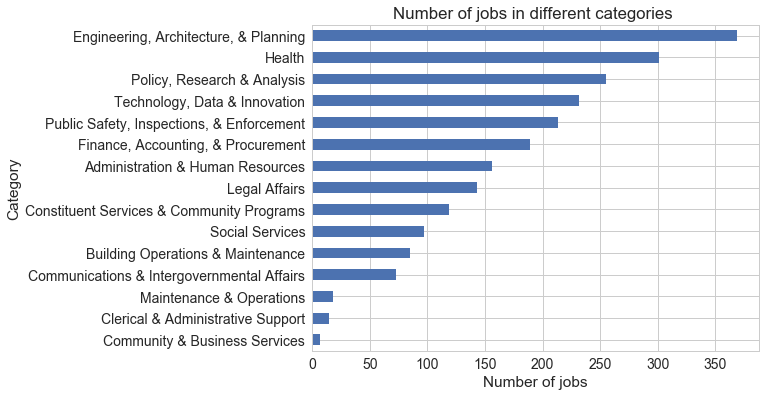

In [14]:
# number of jobs in each category (last 15 columns)
sns.set(style='whitegrid', font_scale=1.4)
plt.figure(figsize=(8, 6))
df[category_list].sum(axis=0).sort_values().plot(kind='barh')
plt.title('Number of jobs in different categories ')
plt.xlabel('Number of jobs')
plt.ylabel('Category')
plt.show()

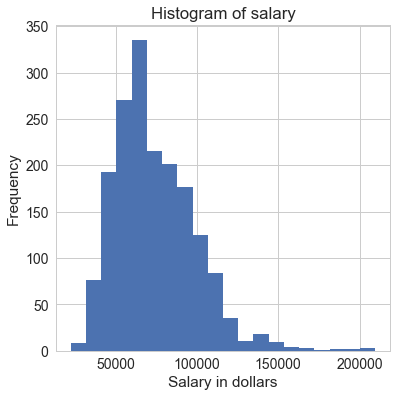

In [15]:
plt.figure(figsize=(6, 6))
plt.hist(df['salary'], bins=20)
plt.title('Histogram of salary')
plt.xlabel('Salary in dollars')
plt.ylabel('Frequency')
plt.show()

In [16]:
# store salary of each category in a dictionary
salary = {}
for i in range(15):
    salary[category_list[i]] = df.salary[df[category_list[i]]==1].tolist()

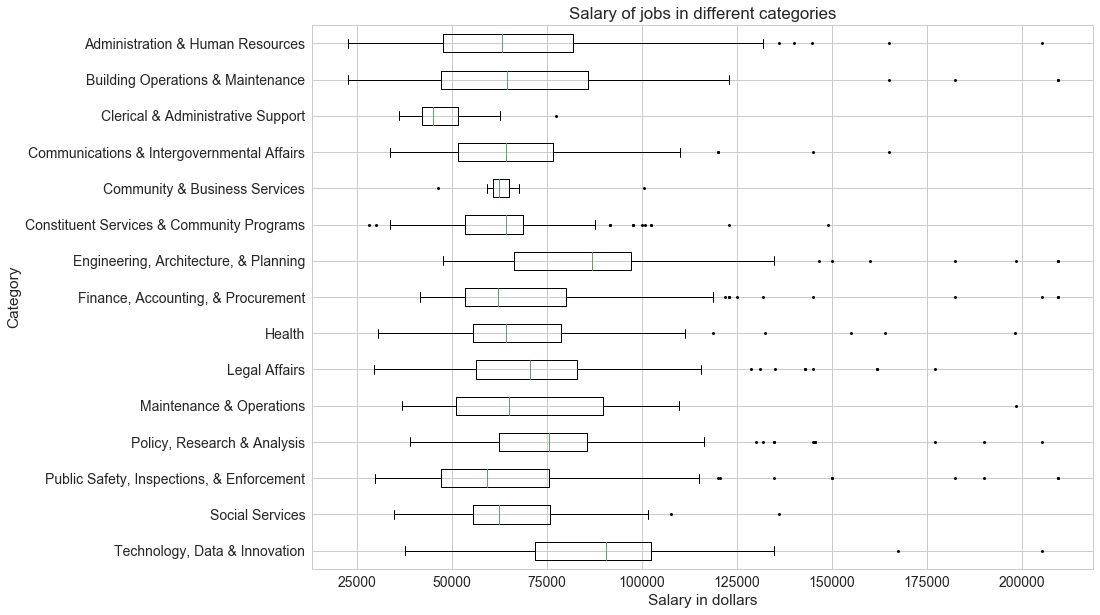

In [17]:
# plot boxplot of salary for different categories
plt.figure(figsize=(14, 10))
plt.boxplot(salary.values(), labels=salary.keys(), sym='k.', vert=False)
plt.xticks()
plt.title('Salary of jobs in different categories')
plt.ylabel('Category')
plt.xlabel('Salary in dollars')
plt.gca().invert_yaxis() # invert y axis to have categories in alphabetical order
plt.show()

#### Text preprocessing - title, job description, required qualification, preferred skills

In [18]:
# replace nans (nans converted to string 'nan') in required_qual and preferred_skills with empty string
df['required_qual'] = df.required_qual.apply(lambda x: x.replace('nan', ''))
df['preferred_skills'] = df.preferred_skills.apply(lambda x: x.replace('nan', ''))

In [19]:
# preparing for text preprocessing: tokenizer, stopwords, and lemmatizer
tokenizer = RegexpTokenizer(r'\w+')
stopwords_en = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [20]:
# text preprocessing: remove special characters, remove digits, tokenize, remove tokens with 2 letters or fewer,
# lowercase, remove stopwords, lemmatize
def preprocess(text):
    text = re.sub('[^a-zA-Z]', ' ', text )
    text = re.sub(r'\s+', ' ', text)
    tokens = tokenizer.tokenize(text)
    tokens = [token.lower() for token in tokens if len(token) > 2]
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_en]
    return ' '.join(tokens) # change from list to string

In [21]:
# preprocess text in text columns that will be analyzed
df['title1'] = df.title
job_cols = ['title', 'job_description', 'required_qual', 'preferred_skills']
for col in job_cols:
    df[col] = df[col].apply(preprocess)

In [22]:
# join title, job_description, required_qual, preferred_skills in one column
df['text'] = df[job_cols].apply(lambda x: ' '.join(x), axis=1)

#### A very preliminary look at some common words in job ads

In [23]:
# definition for plotting n most common words in column with text
def plot_common_words(column, n):
    fdist = Counter(' '.join(row for row in df[column]).split()).most_common(n) # freq distribution of 20 most common words
    word = [i[0] for i in fdist]
    count = [i[1] for i in fdist]
    word_pos = [i for i, _ in enumerate(word)]
    
    plt.figure(figsize=(8, 6))
    plt.barh(word_pos, count)
    plt.yticks(word_pos, word)
    plt.ylabel("word")
    plt.xlabel("count")
    plt.title("Frequency of 20 most common words in {}".format(column))
    plt.gca().invert_yaxis() # invert y axis to descending order
    plt.show()

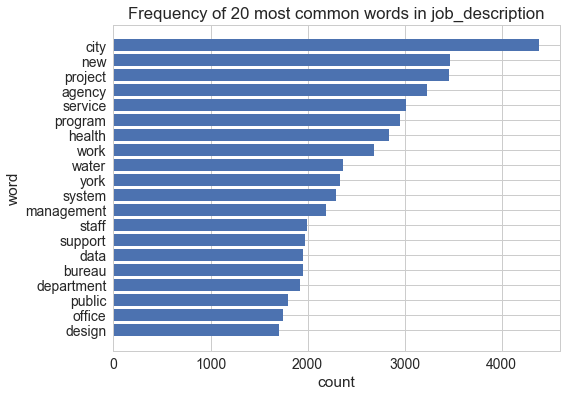

In [24]:
plot_common_words('job_description', 20)

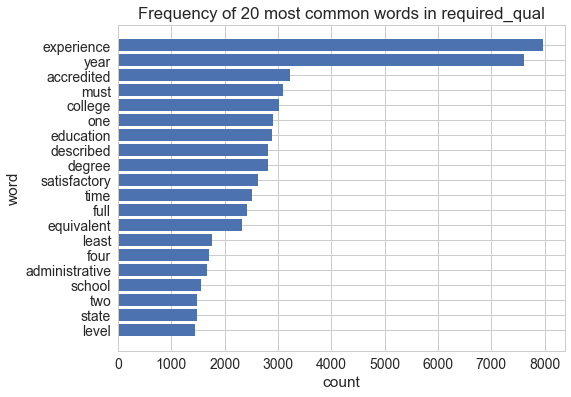

In [25]:
plot_common_words('required_qual', 20)

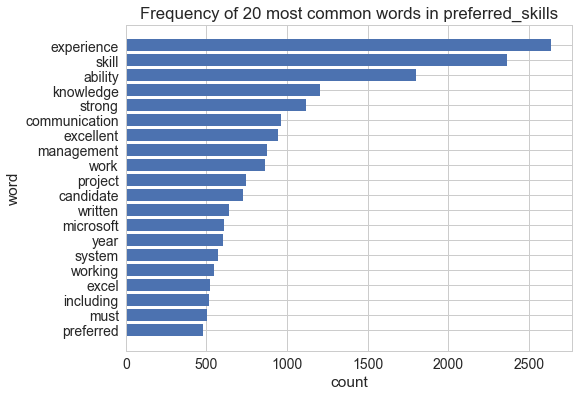

In [26]:
plot_common_words('preferred_skills', 20)

## Predictive model building
Vectorize text (including title, job description, required qualifications, and preferred skills) using TfidfVectorizer, and use tfidf as features to predict job salary
#### Ridge regression

In [27]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.salary, test_size=0.3, random_state=42)

In [28]:
# pipeline with ridge as regressor
pl_ridge = Pipeline([('vectorizer', TfidfVectorizer(ngram_range=(1, 2), max_features=100000)), # unigrams and bigrams
                     ('regressor', Ridge())])

# hyperparameter tuning and cross validation with gridsearchcv
params_ridge = {'regressor__alpha': np.arange(0, 1, 0.1)}
gs_ridge = GridSearchCV(pl_ridge, params_ridge, cv=5)

# fit gs cv object to training data
gs_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'regressor__alpha': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
# predict on test data and compute metrics
y_pred_ridge = gs_ridge.predict(X_test)
r2_ridge = gs_ridge.score(X_test, y_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print("Tuned ridge regression best alpha: {}".format(gs_ridge.best_params_))
print("Tuned ridge regression R squared: {0:.4f}".format(r2_ridge))
print("Tuned ridge regression RMSE: {:5d}".format(int(np.sqrt(mse_ridge))))

Tuned ridge regression best alpha: {'regressor__alpha': 0.10000000000000001}
Tuned ridge regression R squared: 0.7238
Tuned ridge regression RMSE: 13463


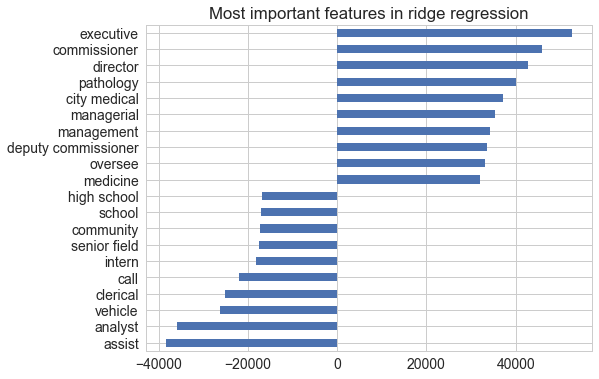

In [32]:
# plot most important features
# get feature coefficients from ridge with best hyperparameter
coefs_ridge = pd.Series(gs_ridge.best_estimator_.named_steps['regressor'].coef_,
                        index = gs_ridge.best_estimator_.named_steps['vectorizer'].get_feature_names())
# features most predictive of lower and higher salary
important_coefs_ridge = pd.concat([coefs_ridge.sort_values().head(10), coefs_ridge.sort_values().tail(10)])

plt.figure(figsize=(8, 6))
important_coefs_ridge.plot(kind='barh')
plt.title('Most important features in ridge regression')
plt.show()

#### Lasso regression

In [33]:
# pipeline with lasso regression
pl_lasso= Pipeline([('vectorizer', TfidfVectorizer(ngram_range=(1, 2), max_features=100000)), # unigrams and bigrams
                     ('regressor', Lasso())])

# hyperparameter tuning and cross validation with gridsearchcv
params_lasso = {'regressor__alpha': np.arange(0, 1, 0.1)}
gs_lasso = GridSearchCV(pl_lasso, params_lasso, cv=5)

# fit gridsearch cv object to training data
gs_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'regressor__alpha': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
# predict on test data and find metrics
y_pred_lasso = gs_lasso.predict(X_test)
r2_lasso = gs_lasso.score(X_test, y_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print("Tuned lasso regression best alpha: {}".format(gs_lasso.best_params_))
print("Tuned lasso regression R squared: {0:.4f}".format(r2_lasso))
print("Tuned lasso regression RMSE: {:5d}".format(int(np.sqrt(mse_lasso))))

Tuned lasso regression best alpha: {'regressor__alpha': 0.90000000000000002}
Tuned lasso regression R squared: 0.6667
Tuned lasso regression RMSE: 14790


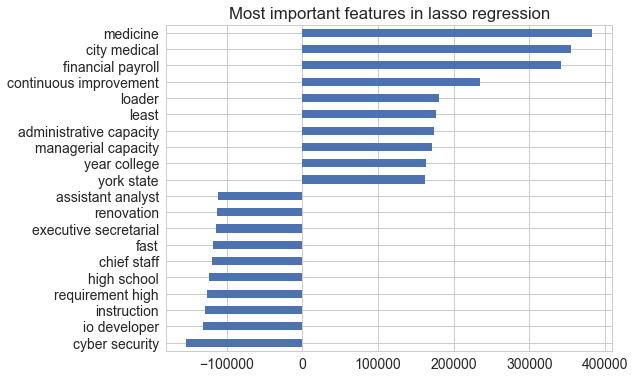

In [35]:
# plot most important features
# get feature coefficients from lasso with best hyperparameter
coefs_lasso = pd.Series(gs_lasso.best_estimator_.named_steps['regressor'].coef_,
                        index = gs_lasso.best_estimator_.named_steps['vectorizer'].get_feature_names())
# features most predictive of lower and higher salary
important_coefs_lasso = pd.concat([coefs_lasso.sort_values().head(10), coefs_lasso.sort_values().tail(10)])

plt.figure(figsize=(8, 6))
important_coefs_lasso.plot(kind='barh')
plt.title('Most important features in lasso regression')
plt.show()

#### Random forest

In [36]:
# pipeline with random forest
pl_rf= Pipeline([('vectorizer', TfidfVectorizer(ngram_range=(1, 2), max_features=100000)), # unigrams and bigrams
                 ('regressor', RandomForestRegressor())])

# hyperparameter tuning and cross validation with randomizedsearchcv
params_rf = {'regressor__n_estimators': [10, 20, 40, 60, 80],
             'regressor__max_features': ['auto', 'sqrt'],
             'regressor__max_depth': [20, 40, 60],
             'regressor__min_samples_split': [2, 5],
             'regressor__min_samples_leaf': [1, 2]}
gs_rf = RandomizedSearchCV(pl_rf, params_rf, cv=5, random_state=42, n_jobs=-1)

# fit gs cv object to training data
gs_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=...timators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'regressor__n_estimators': [10, 20, 40, 60, 80], 'regressor__max_features': ['auto', 'sqrt'], 'regressor__max_depth': [20, 40, 60], 'regressor__min_samples_split': [2, 5], 'regressor__min_samples_leaf': [1, 2]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [37]:
# predict on test data and find metrics
y_pred_rf = gs_rf.predict(X_test)
r2_rf = gs_rf.score(X_test, y_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Tuned random forest best hyperparameters: {}".format(gs_rf.best_params_))
print("Tuned random forest R squared: {0:.4f}".format(r2_rf))
print("Tuned random forest RMSE: {:5d}".format(int(np.sqrt(mse_rf))))

Tuned random forest best hyperparameters: {'regressor__n_estimators': 80, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'auto', 'regressor__max_depth': 40}
Tuned random forest R squared: 0.6559
Tuned random forest RMSE: 15027


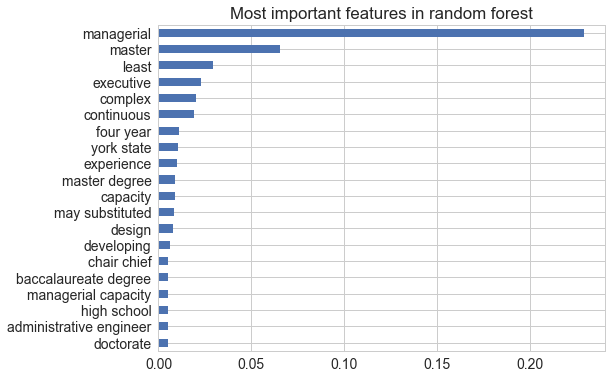

In [38]:
# get feature importance from model with best random forest hyperparameters
feature_importance = pd.Series(gs_rf.best_estimator_.named_steps['regressor'].feature_importances_,
                               index = gs_rf.best_estimator_.named_steps['vectorizer'].get_feature_names())
plt.figure(figsize=(8, 6))
feature_importance.sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Most important features in random forest')
plt.gca().invert_yaxis()
plt.show()

Ridge regression appears to perform better than lasso and random forest with this dataset. <br> Possible future steps: <br> - better text preprocessing e.g. stemming; <br> - transformation of target variable (salary); <br> - other models e.g. neural network; <br> - get a larger number of and more diverse job ads!

### Topic modeling and recommender system with NMF
#### Topic modeling: What kinds of jobs are out there for psychology majors? 

In [69]:
# extract job posts containing psychology
df['psych'] = df.text.apply(lambda x: 1 if re.search('psychology', x) else 0)
psych = df[df.psych==1]

In [70]:
psych.shape

(113, 33)

In [71]:
# vectorize text in job description
vectorizer = TfidfVectorizer()
job_description_vec = vectorizer.fit_transform(psych.job_description) 

In [72]:
# fit nmf model
num_topics = 6
nmf = NMF(n_components = num_topics, random_state=42, alpha=0.1)
nmf.fit(job_description_vec)

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=6, random_state=42, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)

In [73]:
# definition for getting top words in each topic
def get_nmf_topics(model, n_top_words):
    features = vectorizer.get_feature_names()
    
    word_dict = {};
    # for each topic, get the largest weights, and save the corresponding words into the dictionary
    for i in range(num_topics):
        ids = nmf.components_[i].argsort()[-n_top_words:] 
        word_dict['Topic ' + '{:01d}'.format(i+1)] = [features[id] for id in reversed(ids)]
        # word_ids is ordered such that largest weight is the last item, reverse it to have it as first item
    return pd.DataFrame(word_dict);

In [83]:
nmf_topics = get_nmf_topics(nmf, 10)
nmf_topics

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
0,personnel,capital,health,nypd,data,budget
1,division,dep,child,police,program,financial
2,human,water,care,oig,training,expenditure
3,hiring,wastewater,school,city,service,agency
4,civil,contract,mental,investigative,business,monitoring
5,employee,bureau,service,investigation,performance,expense
6,labor,budget,program,public,development,omb
7,process,day,family,investigator,project,modification
8,service,project,bureau,york,initiative,capital
9,resource,procurement,control,increasing,agency,fiscal


Possible types of psychology-related jobs
<br> Topic 1: human resources
<br> Topic 2: water treatment project ??? (description of water treatment project in job ads posted by Dept of Environment Protection)
<br> Topic 3: mental health (often related to early childhood cases)
<br> Topic 4: investigator
<br> Topic 5: program/policy evaluation (often involving data analysis)
<br> Topic 6: budget analysis 

#### Visualization of topic extraction

In [44]:
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

Loading BokehJS ...

Reduce 6-d representation of topics to 2-d space using tsne

In [46]:
# topic representation of documents
nmf_doc_topics = nmf.transform(job_description_vec)

# tsne with 2 components
tsne = TSNE(n_components=2, random_state=42)
tsne_nmf = tsne.fit_transform(nmf_doc_topics)

visualize t-sne with Bokeh

In [47]:
# find most likely topic for each job ad
topic_idx = []
for i in range(nmf_doc_topics.shape[0]):
    topic_idx +=  nmf_doc_topics[i].argmax()

In [48]:
# add tsne and topic variables to the dataframe
psych['tsne1'] = tsne_nmf[:, 0]
psych['tsne2'] = tsne_nmf[:, 1]
psych['topic_idx'] = topic_idx

# color for each topic
color_mapping = {0:'salmon', 1:'lightblue', 2:'olive', 3:'purple', 4:'maroon', 5:'gold'}
psych['color'] = psych.topic_idx.apply(lambda x: color_mapping[x])

# topic summary: use top 6 words from each topic (each column in nmf_topics df)
psych['topic_summary'] = psych.topic_idx.apply(lambda x: 'Topic '+'{:1d}'.format(x+1)+': '+', '.join(nmf_topics.iloc[:,x][:6]))

In [49]:
# change psych df to bokeh data structure
source = ColumnDataSource(psych)

title = 'T-SNE visualization of topics'

plot_nmf = figure(plot_width=800, plot_height=600, title=title,
                  tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                  x_axis_type=None, y_axis_type=None, min_border=1)

plot_nmf.scatter(x='tsne1', y='tsne2', legend='topic_summary', source=source,
                 color='color', alpha=0.8, size=10)

# hover tools - display title, agency of each job post
hover = plot_nmf.select(dict(type=HoverTool))
hover.tooltips = {"Job post": "Title: @title1, Company: @agency, Salary: @salary"}
plot_nmf.legend.location = "bottom_left"

show(plot_nmf)

Future steps:
<br> use a larger and more diverse dataset to extract topics related to a particular degree
<br> find possible ways to evaluate models with different topics
<br> extend the analysis to a pipeline to allow searches of different keywords

#### A simple content-based recommender system
recommending job posts with similar topics to a chosen post

In [75]:
# recommend similar jobs
pl = Pipeline([('vectorizer', TfidfVectorizer()),
               ('nmf', NMF(n_components=30)),
               ('normalizer', Normalizer())])

# apply fit_transform on pl object to get document topic weight matrix
doc_topics = pl.fit_transform(df.text)
doc_topics = pd.DataFrame(doc_topics).set_index(df.index) # use post id in original df as index of nmf_doc_topics df

In [76]:
# function that takes post id as input and returns n number of most similar job posts
def get_recommendations(post_id, n):
    cos_similarities = doc_topics.dot(doc_topics.loc[post_id]) # cosine similarities of post with chosen post_id and other posts
    ids = cos_similarities.sort_values(ascending=False)[1:n+1].index # post ids of n posts with highest cosine similarity
    print('More jobs like Job id: {:6d} '.format(post_id)+'- Title: {}'.format(df.title1[post_id]))
    for id in ids:
        print ('Job id: {:6d} '.format(id)+'- Title: {}'.format(df.title1[id]))

In [81]:
get_recommendations(342AZXz 750, 10)

More jobs like Job id: 342750 - Title: Human Resources Business Partner
Job id: 347063 - Title: DEPUTY DIRECTOR OF HUMAN RESOURCES
Job id: 142473 - Title: Deputy Director, Customer Service
Job id: 345422 - Title: Citywide Learning & Development Associate
Job id: 309097 - Title: Chief of Staff to the Executive Deputy Commissioner
Job id: 357742 - Title: M/WBE Research & Data Analyst
Job id: 357767 - Title: Lease Coordinator
Job id: 366000 - Title: Director of Professional Development
Job id: 367839 - Title: Senior Project Manager for Data Governance
Job id: 346566 - Title: Senior Human Resources Specialist
Job id: 356460 - Title: Project Analyst, Bureau of Facilities Planning and Administrative Services
